In [1]:
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier 
import textdistance

# Configuration initiale de MLflow (facultatif)
import mlflow
mlflow.set_tracking_uri("workspace/ml_runs/")
experiment_name = "ML_FLOW_SEf"
mlflow.set_experiment(experiment_name)




# Lecture des données
df = pd.read_excel("/workspace/DONNEE_LABEL_FAUX_REGROUPER.xlsx")
df2 = pd.read_excel("/workspace/DONNEE_LABEL_VRAI.xlsx")
# Votre prétraitement des données reste inchangé...
i = 4000
df = df.head(i)
# i est la ou je me suis arreté
# Renommer les colonnes par leur position
df = df.rename(columns={df.columns[0]: 'rue_init', df.columns[1]: 'PROP_LEV',df.columns[2]: 'LABEL'})
df = df.replace(np.nan, 0)
df['TYPE_VOIE'] =  df['rue_init'].str.split(' ').str[0]
df = df.replace(np.nan, 1)

df2 = df2.replace(np.nan, 1)
j = 4000
# i est la ou je me suis arreté
df2 = df2.head(j)
df2 = df2.rename(columns={df2.columns[0]: 'rue_init', df2.columns[1]: 'PROP_LEV',df2.columns[2]: 'LABEL'})

df2['TYPE_VOIE'] =  df2['rue_init'].str.split(' ').str[0]
df = pd.concat([df, df2], ignore_index=True)
df['rue_init'] = df['rue_init'].astype(str)
df['PROP_LEV'] = df['PROP_LEV'].astype(str)# Calculer des mesures de similarité
df["damerau_levenshtein"] = df.apply(lambda x: textdistance.damerau_levenshtein.normalized_similarity(x["rue_init"], x["PROP_LEV"]), axis=1)
df["jaro_winkler"] = df.apply(lambda x: textdistance.jaro_winkler(x["rue_init"], x["PROP_LEV"]), axis=1)
df["jaro"] = df.apply(lambda x: textdistance.jaro(x["rue_init"], x["PROP_LEV"]), axis=1)

# Calcul de la mesure de Sørensen-Dice pour chaque paire d'adresses
df['sorensen_dice'] = df.apply(lambda x: textdistance.sorensen_dice(x['rue_init'], x['PROP_LEV']), axis=1)

# Calcul de la plus longue sous-séquence commune (LCS) pour chaque paire d'adresses
df['lcs'] = df.apply(lambda x: textdistance.lcsstr.normalized_similarity(x['rue_init'], x['PROP_LEV']), axis=1)


In [2]:
df

,rue_init,PROP_LEV,LABEL,TYPE_VOIE,damerau_levenshtein,jaro_winkler,jaro,sorensen_dice,lcs
0,A RUE DE L ORMETEAU,AVENUE DE L EUROPE,0.0,A,0.473684,0.790100,0.766778,0.756757,0.421053
1,A RUE DU CHEMIN DE FER,RUE LHOMOND,0.0,A,0.363636,0.530303,0.530303,0.484848,0.181818
2,A RUE DU DOCTEUR ROUX,BD DU COMTE DE MONTALEMBERT,0.0,A,0.296296,0.585538,0.585538,0.625000,0.148148
3,A/43 RUE JEAN BAPTISTE NOTTE,AVENUE JEAN BAPTISTE LEBAS,0.0,A/43,0.642857,0.677839,0.677839,0.740741,0.607143
4,A1 ROUTE NATIONALE,RUE DU HAUIT,0.0,A1,0.222222,0.537037,0.537037,0.533333,0.111111
...,...,...,...,...,...,...,...,...,...
7995,IMPASSE DES CYPRES,IMPASSE DES GEAIS,1.0,IMPASSE,0.722222,0.920261,0.867102,0.800000,0.666667
7996,RESIDENCE DU BOIS ROSE,RESIDENCE BOIS ROSE,1.0,RESIDENCE,0.863636,0.951675,0.919458,0.926829,0.454545
7997,RUE DE WHITSTABLE,RUE DE WHITSTABLE,1.0,RUE,1.000000,1.000000,1.000000,1.000000,1.000000
7998,JACQUES PREVERT,RUE JACQUES PREVERT,1.0,JACQUES,0.789474,0.796491,0.796491,0.882353,0.789474


In [3]:
import seaborn as sns

In [4]:
df.columns

Index(['rue_init', 'PROP_LEV', 'LABEL', 'TYPE_VOIE', 'damerau_levenshtein',
       'jaro_winkler', 'jaro', 'sorensen_dice', 'lcs'],
      dtype='object')

In [5]:
df_corr = df[['damerau_levenshtein',
       'jaro_winkler', 'jaro', 'sorensen_dice', 'lcs']]

<Axes: >

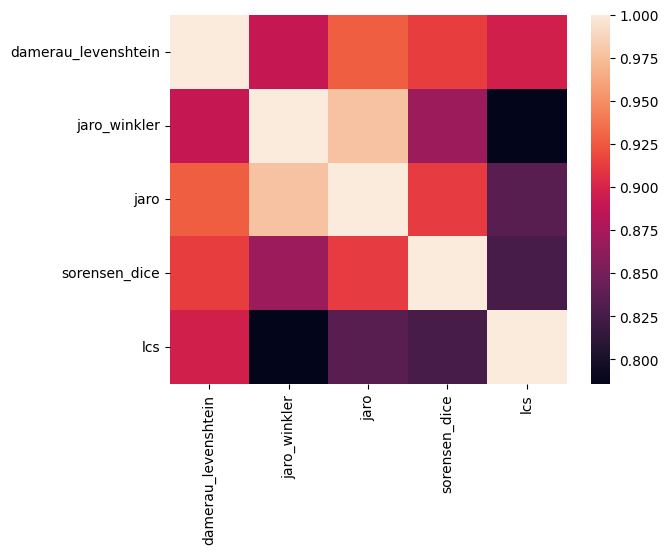

In [6]:
sns.heatmap(df_corr.corr())

In [7]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Préparer les données pour l'entraînement
X = df[["damerau_levenshtein",  "jaro_winkler", "jaro","sorensen_dice", "lcs"]]
y = df["LABEL"]
# jaro sert a rien ici 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=35)


# Commencer une expérience MLflow
with mlflow.start_run():
    
    # Paramètres expérimentaux
    i = 4000
    j = 4000
    test_size = 0.1
    random_state = 35
    
    # Log des paramètres
    mlflow.log_param("i", i)
    mlflow.log_param("j", j)
    mlflow.log_param("test_size", test_size)
    mlflow.log_param("random_state", random_state)
    
   
    # Entraînement du modèle
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    
    # Prédictions et évaluation
    y_pred = model.predict(X_test)
    
    # Log des métriques
    report = classification_report(y_test, y_pred, output_dict=True)
    mlflow.log_metric("precision", report['weighted avg']['precision'])
    mlflow.log_metric("recall", report['weighted avg']['recall'])
    mlflow.log_metric("f1-score", report['weighted avg']['f1-score'])
    
    # Log du modèle
    mlflow.sklearn.log_model(model, "model")
    
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.79      0.85      0.82       391
         1.0       0.84      0.79      0.81       409

    accuracy                           0.82       800
   macro avg       0.82      0.82      0.82       800
weighted avg       0.82      0.82      0.82       800

[[331  60]
 [ 87 322]]


/usr/local/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


              precision    recall  f1-score   support

         0.0       0.79      0.85      0.82       391
         1.0       0.84      0.79      0.81       409

    accuracy                           0.82       800
   macro avg       0.82      0.82      0.82       800
weighted avg       0.82      0.82      0.82       800

[[331  60]
 [ 87 322]]


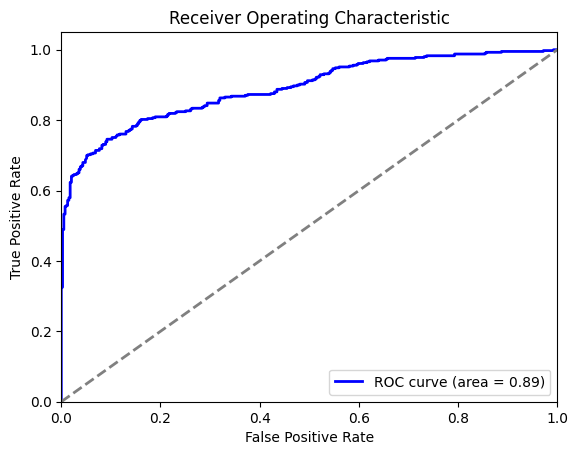

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Prédictions et évaluation
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Log des métriques
report = classification_report(y_test, y_pred, output_dict=True)
mlflow.log_metric("precision", report['weighted avg']['precision'])
mlflow.log_metric("recall", report['weighted avg']['recall'])
mlflow.log_metric("f1-score", report['weighted avg']['f1-score'])

# Log du modèle
mlflow.sklearn.log_model(model, "model")

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Calcul de la courbe ROC et de l'AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Log de l'AUC
mlflow.log_metric("auc", auc)

# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


COURBE ROC ? 

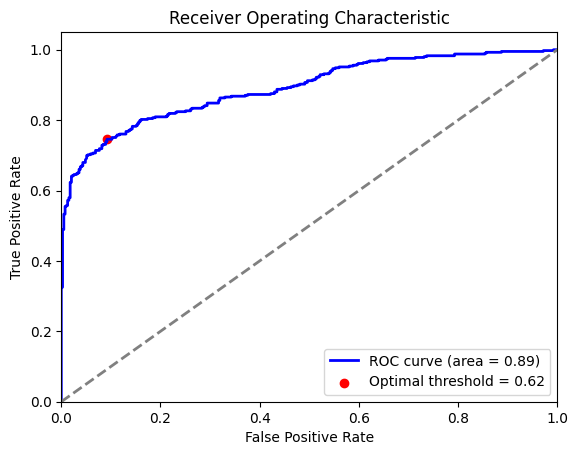

Optimal Threshold: 0.6158385872840881


In [9]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Prédictions des probabilités
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calcul de la courbe ROC et de l'AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Calcul du critère TPR - FPR pour chaque seuil
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Affichage de la courbe ROC avec le seuil optimal
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', marker='o', label=f'Optimal threshold = {optimal_threshold:.2f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f'Optimal Threshold: {optimal_threshold}')


In [10]:
# Utiliser le seuil optimal pour faire des prédictions binaires
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Évaluer la performance avec le seuil optimal
print(classification_report(y_test, y_pred_optimal))
print(confusion_matrix(y_test, y_pred_optimal))


              precision    recall  f1-score   support

         0.0       0.77      0.91      0.84       391
         1.0       0.89      0.75      0.81       409

    accuracy                           0.82       800
   macro avg       0.83      0.83      0.82       800
weighted avg       0.84      0.82      0.82       800

[[355  36]
 [104 305]]


In [11]:
import pickle
from xgboost import XGBClassifier

# Votre processus d'entraînement ici
model.fit(X_train, y_train)

# Chemin où sauvegarder le modèle
pickle_path = "/workspace/pickle_try/xgb_model.pkl"

# Sauvegarde du modèle
with open(pickle_path, "wb") as file:
    pickle.dump(model, file)

print(f"Modèle sauvegardé avec succès à l'emplacement: {pickle_path}")



Modèle sauvegardé avec succès à l'emplacement: /workspace/pickle_try/xgb_model.pkl
